<a href="https://colab.research.google.com/github/yangkeyin/NN-Complex-Singularity/blob/main/%E5%AE%9E%E9%AA%8C%E8%AE%B0%E5%BD%95_20260129_%E5%8F%8C%E9%9A%90%E8%97%8F%E5%B1%82mlp%E4%B8%AD%E5%A5%87%E7%82%B9%E6%9D%83%E9%87%8D%E7%B3%BB%E6%95%B0%E5%8F%98%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

训练中...
Epoch 0, Loss: 8.82e-02
Epoch 5000, Loss: 2.13e-08


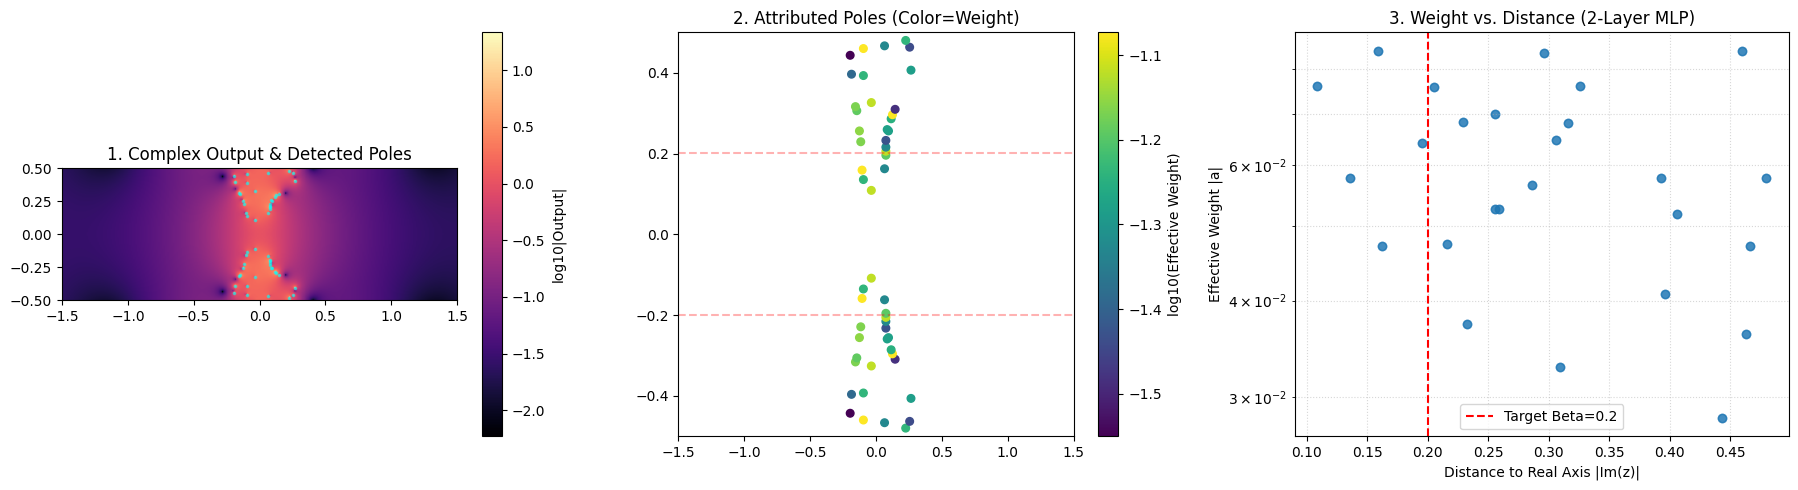

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# ==========================================
# 1. 环境与模型定义 (双层隐藏层)
# ==========================================
def runge_function(x, beta=0.2):
    return 1 / (1 + (x/beta)**2)

class DoubleLayerMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super(DoubleLayerMLP, self).__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        return self.l3(x)

# ==========================================
# 2. 训练阶段 (使用较小的 beta 以产生更近的奇点)
# ==========================================
beta_val = 0.2 # 奇点在 ±0.1i，非常近
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DoubleLayerMLP(hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

x_train = torch.linspace(-1, 1, 2000).view(-1, 1).to(device)
y_train = runge_function(x_train, beta=beta_val)

print("训练中...")
for epoch in range(5001):
    optimizer.zero_grad()
    loss = criterion(model(x_train), y_train)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

# ==========================================
# 3. 复平面推断与奇点追踪逻辑
# ==========================================
def analyze_complex_singularities(model, res=300):
    # ------------------------------------------
    # 1. 坐标网格准备
    # ------------------------------------------
    x_range = np.linspace(-1.5, 1.5, res)
    y_range = np.linspace(-0.5, 0.5, res)
    X, Y = np.meshgrid(x_range, y_range) # numpy矩阵，存储复平面的实部坐标 X 和虚部坐标 Y
    Z_grid = X + 1j * Y # numpy矩阵，形状【300, 300】，存储复数形式的网格输入 z = x + iy
    # z_tensor: 转换为 PyTorch 张量，形状【300, 300, 1】，增加最后一维是为了进行矩阵乘法
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # ------------------------------------------
        # 2. 解析延拓推断 (手动前向传播)
        # ------------------------------------------
        # Layer 1: 模拟 z -> tanh(W1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1 # tensor，形状【300, 300, 256】，线性变换后的结果
        h1 = torch.tanh(h1_pre) # tensor，形状【300, 300, 256】，第一层激活后的复数输出

        # Layer 2: 模拟 h1 -> tanh(W2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2 # tensor，形状【300, 300, 256】，第二层线性变换结果
        h2 = torch.tanh(h2_pre) # tensor，形状【300, 300, 256】，第二层激活后的复数输出

        # Output: 模拟 h2 -> W3*h2 + b3
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3 # tensor，形状【300, 300, 1】，模型的最终复数输出
        # out_abs: 对输出取模，形状【300, 300】，用于生成热力图
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # ------------------------------------------
    # 3. 奇点筛选与定位
    # ------------------------------------------
    threshold = np.percentile(out_abs, 98) # 数值，设定阈值为输出模值最高的 2% 处
    mask = out_abs > threshold # numpy布尔矩阵，形状【300, 300】，标记潜在的奇点候选区域

    found_poles = [] # list，用于存储检测到的复数奇点坐标
    found_weights = [] # list，用于存储每个奇点对应的“贡献权重”

    # 遍历复平面网格（避开边缘），寻找局部最大值（即峰值/极点）
    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]: # 如果当前点在 2% 的高值区域内
                val = out_abs[r, c]
                # 局部极大值判断：比上下左右都大，说明这是一个明确的“峰”
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:

                    # ------------------------------------------
                    # 4. 反向归因追踪 (核心逻辑)
                    # ------------------------------------------
                    z_pt = Z_grid[r, c] # 获取该奇点在复平面上的精确位置
                    # 提取该位置下，各层所有神经元的输出模值
                    h1_val = torch.abs(h1[r, c]).cpu().numpy() # 长度为 256 的向量，记录第一层各神经元的爆炸程度
                    h2_val = torch.abs(h2[r, c]).cpu().numpy() # 长度为 256 的向量，记录第二层各神经元的爆炸程度

                    max_h1 = np.max(h1_val) # 第一层神经元输出的最大值
                    max_h2 = np.max(h2_val) # 第二层神经元输出的最大值

                    # 比较哪一层的神经元更“亢奋”，以此判定奇点来源
                    if max_h1 > max_h2:
                        # 归因于第一层：说明奇点是由第一层神经元的 tanh 内部爆炸引起的
                        idx = np.argmax(h1_val) # 找到罪魁祸首神经元的索引
                        # 权重计算：取该神经元到第二层的所有连接权重的平均模值
                        eff_a = torch.mean(torch.abs(model.l2.weight[:, idx])).item()
                    else:
                        # 归因于第二层：说明奇点产生于第二层的变换过程
                        idx = np.argmax(h2_val) # 找到第二层中爆炸的神经元索引
                        # 权重计算：直接取该神经元到最后输出层的连接权重 a
                        eff_a = torch.abs(model.l3.weight[0, idx]).item()

                    found_poles.append(z_pt) # 存入奇点列表
                    found_weights.append(eff_a) # 存入权重列表

    # 返回：热力图矩阵、奇点数组、权重数组、网格坐标
    return out_abs, np.array(found_poles), np.array(found_weights), X, Y

out_abs, poles, weights, X, Y = analyze_complex_singularities(model)

# ==========================================
# 4. 绘图验证
# ==========================================
plt.figure(figsize=(18, 5))

# 图 1: 复平面输出 (可以看到更丰富的奇点波纹)
plt.subplot(1, 3, 1)
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -0.5, 0.5], origin='lower', cmap='magma')
plt.colorbar(label="log10|Output|")
plt.scatter(poles.real, poles.imag, color='cyan', marker='.', s=10, alpha=0.5)
plt.title("1. Complex Output & Detected Poles")

# 图 2: 归因后的奇点权重分布
plt.subplot(1, 3, 2)
sc = plt.scatter(poles.real, poles.imag, c=np.log10(weights + 1e-12), s=30, cmap='viridis')
plt.colorbar(sc, label="log10(Effective Weight)")
plt.axhline(beta_val, color='red', ls='--', alpha=0.3, label="Target Singularity Im")
plt.axhline(-beta_val, color='red', ls='--', alpha=0.3)
plt.title("2. Attributed Poles (Color=Weight)")
plt.xlim(-1.5, 1.5); plt.ylim(-0.5, 0.5)

# 图 3: 核心验证 - 权重 vs 距离
plt.subplot(1, 3, 3)
dist = np.abs(poles.imag)
plt.scatter(dist, weights, alpha=0.6)
plt.axvline(beta_val, color='red', linestyle='--', label=f'Target Beta={beta_val}')
plt.yscale('log')
plt.xlabel("Distance to Real Axis |Im(z)|")
plt.ylabel("Effective Weight |a|")
plt.title("3. Weight vs. Distance (2-Layer MLP)")
plt.grid(True, which="both", ls=':', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

训练中...
Epoch 0, Loss: 1.26e-01
Epoch 5000, Loss: 1.17e-08


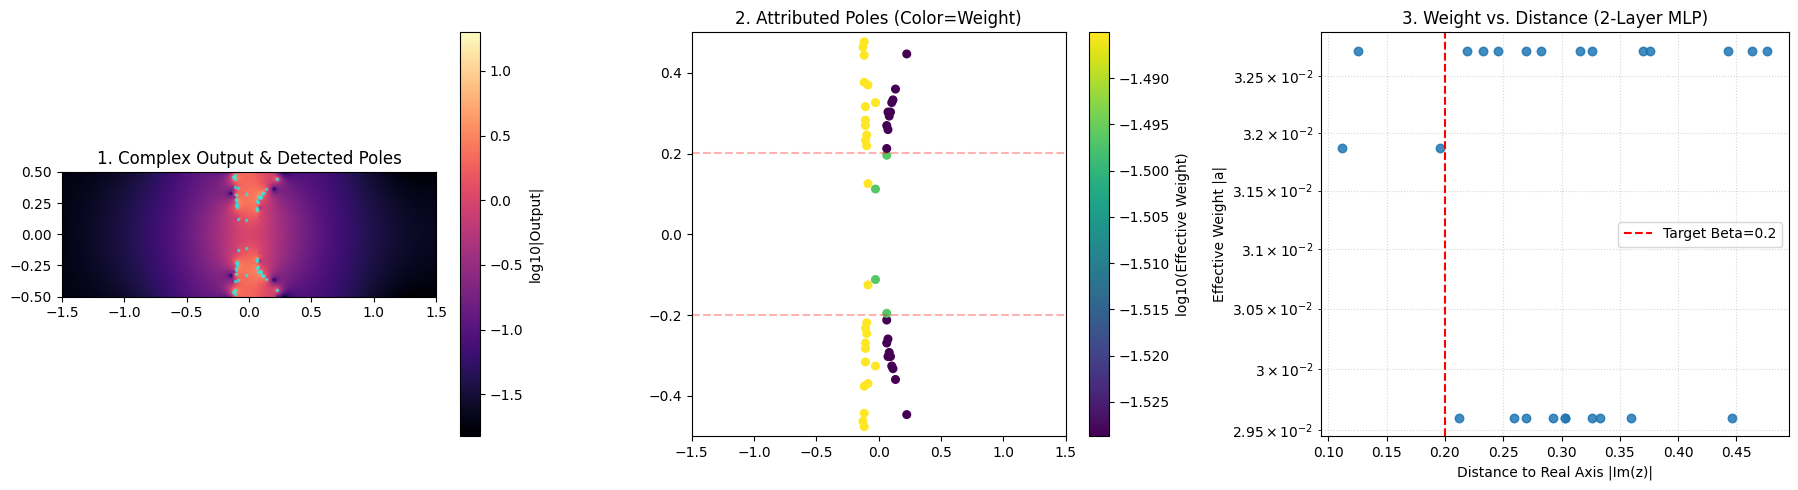

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# ==========================================
# 1. 环境与模型定义 (双层隐藏层)
# ==========================================
def runge_function(x, beta=0.2):
    return 1 / (1 + (x/beta)**2)

class DoubleLayerMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super(DoubleLayerMLP, self).__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        return self.l3(x)

# ==========================================
# 2. 训练阶段 (使用较小的 beta 以产生更近的奇点)
# ==========================================
beta_val = 0.2 # 奇点在 ±0.1i，非常近
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DoubleLayerMLP(hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

x_train = torch.linspace(-1, 1, 2000).view(-1, 1).to(device)
y_train = runge_function(x_train, beta=beta_val)

print("训练中...")
for epoch in range(5001):
    optimizer.zero_grad()
    loss = criterion(model(x_train), y_train)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

# ==========================================
# 3. 复平面推断与奇点追踪逻辑
# ==========================================
def analyze_complex_singularities(model, res=300):
    # ------------------------------------------
    # 1. 坐标网格准备
    # ------------------------------------------
    x_range = np.linspace(-1.5, 1.5, res)
    y_range = np.linspace(-0.5, 0.5, res)
    X, Y = np.meshgrid(x_range, y_range) # numpy矩阵，存储复平面的实部坐标 X 和虚部坐标 Y
    Z_grid = X + 1j * Y # numpy矩阵，形状【300, 300】，存储复数形式的网格输入 z = x + iy
    # z_tensor: 转换为 PyTorch 张量，形状【300, 300, 1】，增加最后一维是为了进行矩阵乘法
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # ------------------------------------------
        # 2. 解析延拓推断 (手动前向传播)
        # ------------------------------------------
        # Layer 1: 模拟 z -> tanh(W1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1 # tensor，形状【300, 300, 256】，线性变换后的结果
        h1 = torch.tanh(h1_pre) # tensor，形状【300, 300, 256】，第一层激活后的复数输出

        # Layer 2: 模拟 h1 -> tanh(W2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2 # tensor，形状【300, 300, 256】，第二层线性变换结果
        h2 = torch.tanh(h2_pre) # tensor，形状【300, 300, 256】，第二层激活后的复数输出

        # Output: 模拟 h2 -> W3*h2 + b3
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3 # tensor，形状【300, 300, 1】，模型的最终复数输出
        # out_abs: 对输出取模，形状【300, 300】，用于生成热力图
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # ------------------------------------------
    # 3. 奇点筛选与定位
    # ------------------------------------------
    threshold = np.percentile(out_abs, 98) # 数值，设定阈值为输出模值最高的 2% 处
    mask = out_abs > threshold # numpy布尔矩阵，形状【300, 300】，标记潜在的奇点候选区域

    found_poles = [] # list，用于存储检测到的复数奇点坐标
    found_weights = [] # list，用于存储每个奇点对应的“贡献权重”

    # 遍历复平面网格（避开边缘），寻找局部最大值（即峰值/极点）
    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]: # 如果当前点在 2% 的高值区域内
                val = out_abs[r, c]
                # 局部极大值判断：比上下左右都大，说明这是一个明确的“峰”
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:

                    # ------------------------------------------
                    # 4. 反向归因追踪 (核心逻辑)
                    # ------------------------------------------
                    z_pt = Z_grid[r, c] # 获取该奇点在复平面上的精确位置
                    # 提取该位置下，各层所有神经元的输出模值
                    h1_val = torch.abs(h1[r, c]).cpu().numpy() # 长度为 256 的向量，记录第一层各神经元的爆炸程度
                    h2_val = torch.abs(h2[r, c]).cpu().numpy() # 长度为 256 的向量，记录第二层各神经元的爆炸程度

                    max_h1 = np.max(h1_val) # 第一层神经元输出的最大值
                    max_h2 = np.max(h2_val) # 第二层神经元输出的最大值


                    # 归因于第一层：说明奇点是由第一层神经元的 tanh 内部爆炸引起的
                    idx = np.argmax(h1_val) # 找到罪魁祸首神经元的索引
                    # 权重计算：取该神经元到第二层的所有连接权重的平均模值
                    eff_a = torch.mean(torch.abs(model.l2.weight[:, idx])).item()

                    found_poles.append(z_pt) # 存入奇点列表
                    found_weights.append(eff_a) # 存入权重列表

    # 返回：热力图矩阵、奇点数组、权重数组、网格坐标
    return out_abs, np.array(found_poles), np.array(found_weights), X, Y

out_abs, poles, weights, X, Y = analyze_complex_singularities(model)

# ==========================================
# 4. 绘图验证
# ==========================================
plt.figure(figsize=(18, 5))

# 图 1: 复平面输出 (可以看到更丰富的奇点波纹)
plt.subplot(1, 3, 1)
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -0.5, 0.5], origin='lower', cmap='magma')
plt.colorbar(label="log10|Output|")
plt.scatter(poles.real, poles.imag, color='cyan', marker='.', s=10, alpha=0.5)
plt.title("1. Complex Output & Detected Poles")

# 图 2: 归因后的奇点权重分布
plt.subplot(1, 3, 2)
sc = plt.scatter(poles.real, poles.imag, c=np.log10(weights + 1e-12), s=30, cmap='viridis')
plt.colorbar(sc, label="log10(Effective Weight)")
plt.axhline(beta_val, color='red', ls='--', alpha=0.3, label="Target Singularity Im")
plt.axhline(-beta_val, color='red', ls='--', alpha=0.3)
plt.title("2. Attributed Poles (Color=Weight)")
plt.xlim(-1.5, 1.5); plt.ylim(-0.5, 0.5)

# 图 3: 核心验证 - 权重 vs 距离
plt.subplot(1, 3, 3)
dist = np.abs(poles.imag)
plt.scatter(dist, weights, alpha=0.6)
plt.axvline(beta_val, color='red', linestyle='--', label=f'Target Beta={beta_val}')
plt.yscale('log')
plt.xlabel("Distance to Real Axis |Im(z)|")
plt.ylabel("Effective Weight |a|")
plt.title("3. Weight vs. Distance (2-Layer MLP)")
plt.grid(True, which="both", ls=':', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# ==========================================
# 1. 环境与模型定义 (双层隐藏层)
# ==========================================
def runge_function(x, beta=0.2):
    return 1 / (1 + (x/beta)**2)

class DoubleLayerMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super(DoubleLayerMLP, self).__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        return self.l3(x)

# ==========================================
# 2. 训练阶段 (使用较小的 beta 以产生更近的奇点)
# ==========================================
beta_val = 0.2 # 奇点在 ±0.1i，非常近
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DoubleLayerMLP(hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

x_train = torch.linspace(-1, 1, 2000).view(-1, 1).to(device)
y_train = runge_function(x_train, beta=beta_val)

print("训练中...")
for epoch in range(5001):
    optimizer.zero_grad()
    loss = criterion(model(x_train), y_train)
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

# ==========================================
# 3. 复平面推断与奇点追踪逻辑
# ==========================================
def analyze_complex_singularities(model, res=400):
    # 1. 坐标与前向推理 (手动复数运算)
    x_range = np.linspace(-1.5, 1.5, res)
    y_range = np.linspace(-0.8, 0.8, res)
    X, Y = np.meshgrid(x_range, y_range)
    Z_grid = X + 1j * Y
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # 第一层输出: h1 = tanh(w1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1
        h1 = torch.tanh(h1_pre) # 形状: [res, res, hidden_size]

        # 第二层输出: h2 = tanh(w2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2
        h2 = torch.tanh(h2_pre) # 形状: [res, res, hidden_size]

        # 最终输出
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # 2. 奇点判断：寻找输出的局部极大值点
    threshold = np.percentile(out_abs, 98)
    mask = out_abs > threshold

    found_poles = []
    found_weights = []
    found_layers = [] # 记录来源：1 代表第一层(蓝), 2 代表第二层(红)

    # 设定一个“神经元爆炸”的阈值，用于判定是否由该层引起
    # 因为 tanh(z) 在奇点处模值会趋于无穷，这里设为 10 已经非常显著了
    activation_threshold = 10.0

    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]:
                val = out_abs[r, c]
                # 局部极大值判断
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:
                    z_pt = Z_grid[r, c]
                    h1_pt = torch.abs(h1[r, c]).cpu().numpy()
                    h2_pt = torch.abs(h2[r, c]).cpu().numpy()

                    # --- 第一层权重系数查找 ---
                    max_h1_val = np.max(h1_pt)
                    if max_h1_val > activation_threshold:
                        j1 = np.argmax(h1_pt)
                        # 权重 |a| = mean_i |w_ij^{(2)}|
                        eff_a = torch.mean(torch.abs(model.l2.weight[:, j1])).item()

                        found_poles.append(z_pt)
                        found_weights.append(eff_a)
                        found_layers.append(1) # 第一层
                        continue # 找到了就直接跳过，进入下一个奇点

                    # --- 第二层权重系数查找 (如果第一层没找到) ---
                    max_h2_val = np.max(h2_pt)
                    if max_h2_val > activation_threshold:
                        i1 = np.argmax(h2_pt)
                        # 权重 |a| = |w_i^{(3)}| (即 model.l3 的权重)
                        eff_a = torch.abs(model.l3.weight[0, i1]).item()

                        found_poles.append(z_pt)
                        found_weights.append(eff_a)
                        found_layers.append(2) # 第二层

    return out_abs, np.array(found_poles), np.array(found_weights), np.array(found_layers), X, Y

out_abs, poles, weights, layers, X, Y = analyze_complex_singularities(model)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -0.5, 0.5], origin='lower', cmap='magma')
plt.colorbar(label="log10|Output|")
plt.scatter(poles.real, poles.imag, color='cyan', marker='.', s=10, alpha=0.5)
plt.title("1. Complex Output & Detected Poles")
# --- 图 2: 奇点来源归因图 (重点修改) ---
plt.subplot(1, 3, 2)
# 分别提取两层的数据
p1 = poles[layers == 1]
w1 = weights[layers == 1]
p2 = poles[layers == 2]
w2 = weights[layers == 2]

# 绘制背景热力图
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -0.5, 0.5],
           origin='lower', cmap='Greys', alpha=0.3)

# 绘制第一层奇点 (蓝色)
if len(p1) > 0:
    plt.scatter(p1.real, p1.imag, s=w1 * 500, c='blue', alpha=0.6,
                label='From Layer 1 (Blue)', edgecolors='w', linewidths=0.5)

# 绘制第二层奇点 (红色)
if len(p2) > 0:
    plt.scatter(p2.real, p2.imag, s=w2 * 500, c='red', alpha=0.6,
                label='From Layer 2 (Red)', edgecolors='w', linewidths=0.5)

plt.axhline(beta_val, color='red', ls='--', alpha=0.3, label="Target Singularity Im")
plt.axhline(-beta_val, color='red', ls='--', alpha=0.3)
plt.title("2. Singularity Attribution (Color=Layer, Size=|a|)")
plt.xlabel("Re(z)"); plt.ylabel("Im(z)")
plt.legend()

# --- 图 3: 相关性分析 ---
plt.subplot(1, 3, 3)
dist = np.abs(poles.imag)
# 同样根据层数着色，观察不同层奇点是否遵循相同的衰减规律
plt.scatter(dist[layers==1], weights[layers==1], c='blue', alpha=0.5, label='Layer 1')
plt.scatter(dist[layers==2], weights[layers==2], c='red', alpha=0.5, label='Layer 2')
plt.axvline(0.1, color='green', linestyle='--', label='Runge Beta (0.1)')
plt.yscale('log')
plt.xlabel("Distance |Im(z)|")
plt.ylabel("Weight |a|")
plt.title("3. Weight vs Distance by Layer")
plt.legend()

plt.tight_layout()
plt.show()

训练中...
Epoch 0, Loss: 2.43e-01


KeyboardInterrupt: 

In [ ]:
print(h1_pt)

NameError: name 'h1_pt' is not defined

In [ ]:
import numpy as np

# numpy科学计数法数字
np_num = np.array([1.23e5, 4.56e-6])
# 修改配置：关闭科学计数法，保留6位小数
np.set_printoptions(suppress=True, precision=6)
# 输出常规形式
print(np_num)  # 输出：[123000.      0.000005]

def analyze_complex_singularities(model, res=400):
    # 1. 坐标与前向推理 (手动复数运算)
    x_range = np.linspace(-1.5, 1.5, res)
    y_range = np.linspace(-1.5, 1.5, res)
    X, Y = np.meshgrid(x_range, y_range)
    Z_grid = X + 1j * Y
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # 第一层输出: h1 = tanh(w1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1
        h1 = torch.tanh(h1_pre) # 形状: [res, res, hidden_size]

        # 第二层输出: h2 = tanh(w2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2
        h2 = torch.tanh(h2_pre) # 形状: [res, res, hidden_size]

        # 最终输出
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # 2. 奇点判断：寻找输出的局部极大值点
    threshold = np.percentile(out_abs, 98)
    mask = out_abs > threshold

    found_poles = []
    found_weights = []
    found_layers = [] # 记录来源：1 代表第一层(蓝), 2 代表第二层(红)

    # 设定一个“神经元爆炸”的阈值，用于判定是否由该层引起
    # 因为 tanh(z) 在奇点处模值会趋于无穷，这里设为 10 已经非常显著了
    activation_threshold = 10.0

    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]:
                val = out_abs[r, c]
                # 局部极大值判断
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:
                    z_pt = Z_grid[r, c]
                    h1_pt = torch.abs(h1[r, c]).cpu().numpy()
                    h2_pt = torch.abs(h2[r, c]).cpu().numpy()
                    # --- 第一层权重系数查找 ---
                    max_h1_val = np.max(h1_pt)
                    if max_h1_val > activation_threshold:
                        j1 = np.argmax(h1_pt)
                        # 权重 |a| = mean_i |w_ij^{(2)}|
                        eff_a = torch.mean(torch.abs(model.l2.weight[:, j1])).item()

                        found_poles.append(z_pt)
                        found_weights.append(eff_a)
                        found_layers.append(1) # 第一层
                        continue # 找到了就直接跳过，进入下一个奇点

                    # --- 第二层权重系数查找 (如果第一层没找到) ---
                    max_h2_val = np.max(h2_pt)
                    if max_h2_val > activation_threshold:
                        i1 = np.argmax(h2_pt)
                        # 权重 |a| = |w_i^{(3)}| (即 model.l3 的权重)
                        eff_a = torch.abs(model.l3.weight[0, i1]).item()

                        found_poles.append(z_pt)
                        found_weights.append(eff_a)
                        found_layers.append(2) # 第二层

    return out_abs, np.array(found_poles), np.array(found_weights), np.array(found_layers), X, Y

out_abs, poles, weights, layers, X, Y = analyze_complex_singularities(model)

[123000.            0.000005]


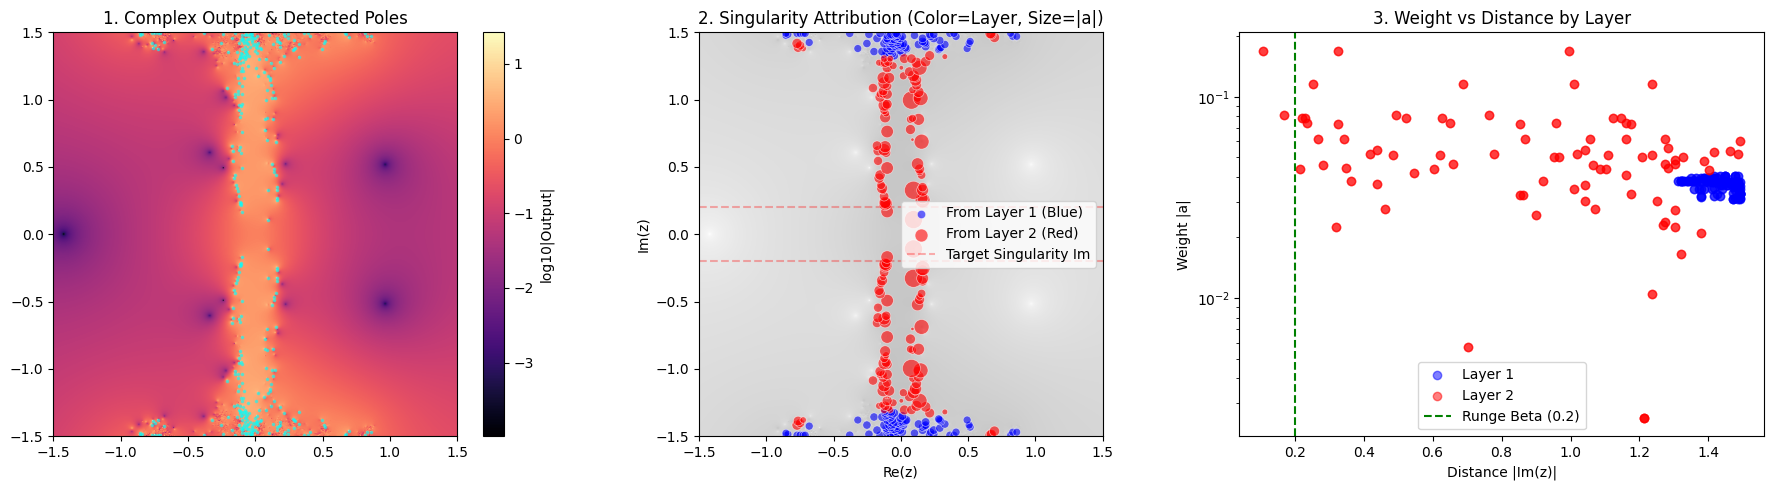

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -1.5, 1.5], origin='lower', cmap='magma')
plt.colorbar(label="log10|Output|")
plt.scatter(poles.real, poles.imag, color='cyan', marker='.', s=10, alpha=0.5)
plt.title("1. Complex Output & Detected Poles")
# --- 图 2: 奇点来源归因图 (重点修改) ---
plt.subplot(1, 3, 2)
# 分别提取两层的数据
p1 = poles[layers == 1]
w1 = weights[layers == 1]
p2 = poles[layers == 2]
w2 = weights[layers == 2]

# 绘制背景热力图
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -1.5, 1.5],
           origin='lower', cmap='Greys', alpha=0.3)

# 绘制第一层奇点 (蓝色)
if len(p1) > 0:
    plt.scatter(p1.real, p1.imag, s=w1 * 1000, c='blue', alpha=0.6,
                label='From Layer 1 (Blue)', edgecolors='w', linewidths=0.5)

# 绘制第二层奇点 (红色)
if len(p2) > 0:
    plt.scatter(p2.real, p2.imag, s=w2 * 1000, c='red', alpha=0.6,
                label='From Layer 2 (Red)', edgecolors='w', linewidths=0.5)

plt.axhline(beta_val, color='red', ls='--', alpha=0.3, label="Target Singularity Im")
plt.axhline(-beta_val, color='red', ls='--', alpha=0.3)
plt.title("2. Singularity Attribution (Color=Layer, Size=|a|)")
plt.xlabel("Re(z)"); plt.ylabel("Im(z)")
plt.legend()

# --- 图 3: 相关性分析 ---
plt.subplot(1, 3, 3)
dist = np.abs(poles.imag)
# 同样根据层数着色，观察不同层奇点是否遵循相同的衰减规律
plt.scatter(dist[layers==1], weights[layers==1], c='blue', alpha=0.5, label='Layer 1')
plt.scatter(dist[layers==2], weights[layers==2], c='red', alpha=0.5, label='Layer 2')
plt.axvline(0.2, color='green', linestyle='--', label='Runge Beta (0.2)')
plt.yscale('log')
plt.xlabel("Distance |Im(z)|")
plt.ylabel("Weight |a|")
plt.title("3. Weight vs Distance by Layer")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 获取数据
out_abs, poles, weights, layers, X, Y = analyze_complex_singularities(model)

plt.figure(figsize=(20, 10))

# [图 1 和图 4 保持你之前的代码逻辑...]

# --- 图 2: 奇点来源归因图 (重点修改) ---
plt.subplot(2, 2, 2)
# 分别提取两层的数据
p1 = poles[layers == 1]
w1 = weights[layers == 1]
p2 = poles[layers == 2]
w2 = weights[layers == 2]

# 绘制背景热力图
plt.imshow(np.log10(out_abs + 1e-10), extent=[-1.5, 1.5, -0.5, 0.5],
           origin='lower', cmap='Greys', alpha=0.3)

# 绘制第一层奇点 (蓝色)
if len(p1) > 0:
    plt.scatter(p1.real, p1.imag, s=w1 * 5000, c='blue', alpha=0.6,
                label='From Layer 1 (Blue)', edgecolors='w', linewidths=0.5)

# 绘制第二层奇点 (红色)
if len(p2) > 0:
    plt.scatter(p2.real, p2.imag, s=w2 * 5000, c='red', alpha=0.6,
                label='From Layer 2 (Red)', edgecolors='w', linewidths=0.5)

plt.axhline(0, color='black', lw=1)
plt.title("2. Singularity Attribution (Color=Layer, Size=|a|)")
plt.xlabel("Re(z)"); plt.ylabel("Im(z)")
plt.legend()

# --- 图 3: 相关性分析 ---
plt.subplot(2, 2, 3)
dist = np.abs(poles.imag)
# 同样根据层数着色，观察不同层奇点是否遵循相同的衰减规律
plt.scatter(dist[layers==1], weights[layers==1], c='blue', alpha=0.5, label='Layer 1')
plt.scatter(dist[layers==2], weights[layers==2], c='red', alpha=0.5, label='Layer 2')
plt.axvline(0.1, color='green', linestyle='--', label='Runge Beta (0.1)')
plt.yscale('log')
plt.xlabel("Distance |Im(z)|")
plt.ylabel("Weight |a|")
plt.title("3. Weight vs Distance by Layer")
plt.legend()

plt.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 6, got 5)

开始训练双层模型...
Epoch 0, Loss: 1.55e-01
Epoch 2000, Loss: 3.28e-07
Epoch 4000, Loss: 3.72e-08


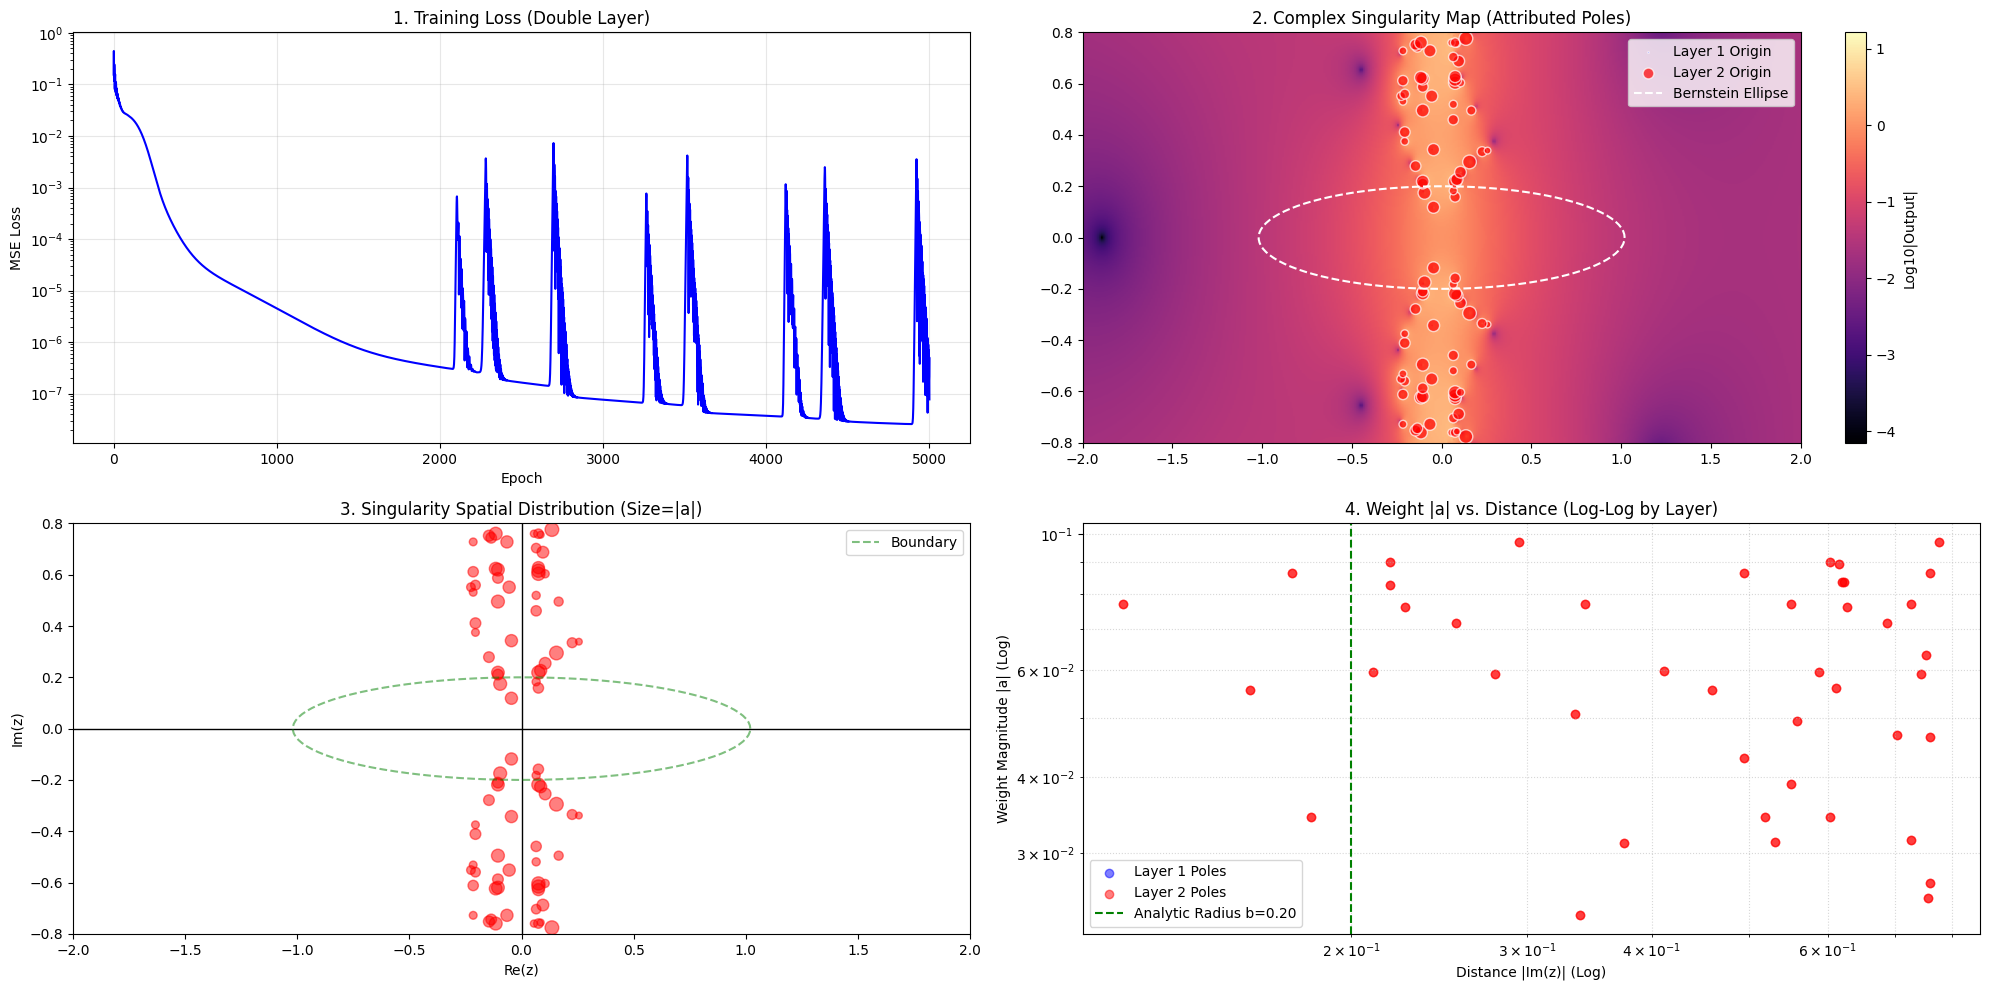

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 构建目标函数 (Runge Function)
# ==========================================
def runge_function(x, beta=0.2):
    return 1 / (1 + (x/beta)**2)

# ==========================================
# 2. 定义双层 MLP 模型
# ==========================================
class DoubleLayerMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super(DoubleLayerMLP, self).__init__()
        # 使用两层隐藏层以产生更复杂的奇点动力学
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        return self.l3(x)

# ==========================================
# 3. 训练模型
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DoubleLayerMLP(hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

beta_val = 0.2
x_train = torch.linspace(-1, 1, 2000).view(-1, 1).to(device)
y_train = runge_function(x_train, beta=beta_val)

losses = []
print("开始训练双层模型...")
for epoch in range(5001):
    optimizer.zero_grad()
    loss = criterion(model(x_train), y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

# ==========================================
# 4. 核心逻辑：复平面奇点探测与归因 (按要求重写)
# ==========================================
def analyze_complex_singularities(model, res=400):
    x_range = np.linspace(-2.0, 2.0, res)
    y_range = np.linspace(-0.8, 0.8, res)
    X, Y = np.meshgrid(x_range, y_range)
    Z_grid = X + 1j * Y
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # 第一层：h1 = tanh(w1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1
        h1 = torch.tanh(h1_pre)

        # 第二层：h2 = tanh(w2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2
        h2 = torch.tanh(h2_pre)

        # 输出层
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # 1. 奇点判断：寻找输出模值的局部极大值
    threshold = np.percentile(out_abs, 98)
    mask = out_abs > threshold

    found_poles = []
    found_weights = []
    found_layers = [] # 1 代表第一层，2 代表第二层

    # 神经元爆炸判定阈值 (tanh(z) 靠近奇点时会很大)
    activation_limit = 10.0

    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]:
                val = out_abs[r, c]
                # 寻找峰值
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:
                    h1_pt = torch.abs(h1[r, c]).cpu().numpy()
                    h2_pt = torch.abs(h2[r, c]).cpu().numpy()

                    # 优先级 1：第一层权重系数查找
                    if np.max(h1_pt) > activation_limit:
                        j1 = np.argmax(h1_pt)
                        # 权重取第二层对应神经元连接的平均模值
                        eff_a = torch.mean(torch.abs(model.l2.weight[:, j1])).item()

                        found_poles.append(Z_grid[r, c])
                        found_weights.append(eff_a)
                        found_layers.append(1)
                        continue # 满足第一层则跳过

                    # 优先级 2：第二层权重系数查找
                    if np.max(h2_pt) > activation_limit:
                        i1 = np.argmax(h2_pt)
                        # 权重直接取输出层的权重 a_i
                        eff_a = torch.abs(model.l3.weight[0, i1]).item()

                        found_poles.append(Z_grid[r, c])
                        found_weights.append(eff_a)
                        found_layers.append(2)

    return out_abs, np.array(found_poles), np.array(found_weights), np.array(found_layers), X, Y

# 执行分析
out_abs, poles, weights, layers, X, Y = analyze_complex_singularities(model)

# ==========================================
# 5. 绘图与结果展示
# ==========================================
plt.figure(figsize=(20, 10))

# 图 1: Loss 曲线 (保持不变)
plt.subplot(2, 2, 1)
plt.semilogy(losses, color='blue')
plt.title("1. Training Loss (Double Layer)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.grid(True, alpha=0.3)

# 图 2: 复平面推断图 (Singularity Map) - 包含层级分类
plt.subplot(2, 2, 2)
im = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                origin='lower', cmap='magma', aspect='auto')
plt.colorbar(im, label="Log10|Output|")
# 绘制理想伯恩斯坦椭圆作为参考
rho = beta_val + np.sqrt(beta_val**2 + 1)
theta = np.linspace(0, 2*np.pi, 100)
E_z = 0.5 * (rho * np.exp(1j * theta) + 1/(rho * np.exp(1j * theta)))
plt.plot(E_z.real, E_z.imag, 'r--', lw=1.5, label="Ideal Bernstein Ellipse")
plt.title("2. Complex Singularity Map (Attributed Poles)")
plt.legend(loc='upper right')

# 图 3: 神经元奇点空间分布图 (Re-Im 分布)
plt.subplot(2, 2, 3)
im = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                origin='lower', cmap='magma', aspect='auto')
plt.colorbar(im, label="Log10|Output|")

# 按层级绘制奇点：第一层(蓝色)，第二层(红色)，大小随权重变化
if len(poles) > 0:
    p1 = poles[layers == 1]; w1 = weights[layers == 1]
    p2 = poles[layers == 2]; w2 = weights[layers == 2]

    plt.scatter(p1.real, p1.imag, s=w1*1000, c='blue', alpha=0.7, label='Layer 1 Origin', edgecolors='white')
    plt.scatter(p2.real, p2.imag, s=w2*1000, c='red', alpha=0.7, label='Layer 2 Origin', edgecolors='white')

# 绘制理想伯恩斯坦椭圆作为参考
rho = beta_val + np.sqrt(beta_val**2 + 1)
theta = np.linspace(0, 2*np.pi, 100)
E_z = 0.5 * (rho * np.exp(1j * theta) + 1/(rho * np.exp(1j * theta)))
plt.plot(E_z.real, E_z.imag, 'r--', lw=1.5, label="Ideal Bernstein Ellipse")
plt.title("3. Neuron Singularity Distribution (Size=|a|)")
plt.legend(loc='upper right')

# 图 4: 相关性趋势图 (双对数坐标)
plt.subplot(2, 2, 4)
if len(poles) > 0:
    dist1 = np.abs(p1.imag); dist2 = np.abs(p2.imag)
    plt.scatter(dist1, w1, c='blue', alpha=0.5, label='Layer 1 Poles')
    plt.scatter(dist2, w2, c='red', alpha=0.5, label='Layer 2 Poles')

ideal_b = 0.5 * (rho - 1/rho)
plt.axvline(ideal_b, color='green', linestyle='--', label=f'Analytic Radius b={ideal_b:.2f}')
plt.xscale('log'); plt.yscale('log')
plt.title("4. Weight |a| vs. Distance (Log-Log by Layer)")
plt.xlabel("Distance |Im(z)| (Log)"); plt.ylabel("Weight Magnitude |a| (Log)")
plt.grid(True, which="both", ls=':', alpha=0.5); plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 0. 挂载 Google Drive 与 路径准备
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/NN-Complex-Singularity/20260129_WeightChangeDoubleLayers/lr1e-4_epochs5000"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建文件夹: {save_dir}")
else:
    print(f"使用已有文件夹: {save_dir}")

# 1. 构建目标函数 (Runge Function)
def runge_function(x, beta=0.2):
    return 1 / (1 + (x/beta)**2)

# 2. 定义 MLP 模型 (双层隐藏层)
class DoubleLayerMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super(DoubleLayerMLP, self).__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        return self.l3(x)

# 3. 解析延拓推理与归因函数
def analyze_complex_singularities(model, device, res=400):
    # 准备复平面网格
    x_range = np.linspace(-2.0, 2.0, res)
    y_range = np.linspace(-0.8, 0.8, res)
    X, Y = np.meshgrid(x_range, y_range)
    Z_grid = X + 1j * Y
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # 第一层：h1 = tanh(w1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1
        h1 = torch.tanh(h1_pre)

        # 第二层：h2 = tanh(w2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2
        h2 = torch.tanh(h2_pre)

        # 输出层
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # 奇点判断
    threshold = np.percentile(out_abs, 98)
    mask = out_abs > threshold

    found_poles = []
    found_weights = []
    found_layers = []
    activation_limit = 10.0 # 判定神经元爆炸的模值阈值

    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]:
                val = out_abs[r, c]
                # 局部极大值判断
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:
                    h1_pt = torch.abs(h1[r, c]).cpu().numpy()
                    h2_pt = torch.abs(h2[r, c]).cpu().numpy()

                    # 优先级 1：第一层权重系数查找 (归因于第1层)
                    if np.max(h1_pt) > activation_limit:
                        j1 = np.argmax(h1_pt)
                        # |a| = 对第二层连接权重的平均模值
                        eff_a = torch.mean(torch.abs(model.l2.weight[:, j1])).item()
                        found_poles.append(Z_grid[r, c])
                        found_weights.append(eff_a)
                        found_layers.append(1)
                        continue

                    # 优先级 2：第二层权重系数查找 (归因于第2层)
                    if np.max(h2_pt) > activation_limit:
                        i1 = np.argmax(h2_pt)
                        # |a| = 最后一层的权重 a_i
                        eff_a = torch.abs(model.l3.weight[0, i1]).item()
                        found_poles.append(Z_grid[r, c])
                        found_weights.append(eff_a)
                        found_layers.append(2)

    return out_abs, np.array(found_poles), np.array(found_weights), np.array(found_layers), X, Y

# 4. 训练与周期性绘图
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DoubleLayerMLP(hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

beta_val = 0.2
x_train = torch.linspace(-1, 1, 2000).view(-1, 1).to(device)
y_train = runge_function(x_train, beta=beta_val)

losses = []
total_epochs = 5001

print("开始训练并记录...")
for epoch in range(total_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # 每 1000 轮绘制并保存图像
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

        # 分析当前状态
        out_abs, poles, weights, layers, X, Y = analyze_complex_singularities(model, device)

        plt.figure(figsize=(20, 10))

        # 图 1: Loss 曲线
        plt.subplot(2, 2, 1)
        plt.semilogy(losses, color='blue')
        plt.title(f"1. Training Loss (Epoch {epoch})")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.grid(True, alpha=0.3)

        # 图 2: 复平面推断图
        plt.subplot(2, 2, 2)
        im = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                        origin='lower', cmap='magma', aspect='auto')
        plt.colorbar(im, label="Log10|Output|")
        plt.scatter([0, 0], [0.2, -0.2], color='cyan', marker='x', s=100, label="Target Poles (±0.2i)")
        # 理想伯恩斯坦椭圆
        rho = beta_val + np.sqrt(beta_val**2 + 1)
        theta = np.linspace(0, 2*np.pi, 100)
        E_z = 0.5 * (rho * np.exp(1j * theta) + 1/(rho * np.exp(1j * theta)))
        plt.plot(E_z.real, E_z.imag, 'w--', lw=1.5, label="Ideal Bernstein Ellipse")
        plt.title("2. Complex Singularity Map (Attributed Poles)")
        plt.legend(loc='upper right', fontsize='small')

        # 图 3: 神经元奇点空间分布图
        plt.subplot(2, 2, 3)
        plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                        origin='lower', cmap='magma', aspect='auto')
        plt.colorbar(im, label="Log10|Output|")
        if len(poles) > 0:
            p1 = poles[layers == 1]; w1 = weights[layers == 1]
            p2 = poles[layers == 2]; w2 = weights[layers == 2]
            if len(p1) > 0:
                plt.scatter(p1.real, p1.imag, s=w1*1000, c='blue', alpha=0.7, label='Layer 1 Origin', edgecolors='white')
            if len(p2) > 0:
                plt.scatter(p2.real, p2.imag, s=w2*1000, c='red', alpha=0.7, label='Layer 2 Origin', edgecolors='white')
        plt.plot(E_z.real, E_z.imag, 'w--', lw=1.5, label="Ideal Bernstein Ellipse")
        plt.title("3. Neuron Singularity Distribution (Size=|a|)")
        plt.legend(loc='upper right', fontsize='small')

        # 图 4: 相关性趋势图
        plt.subplot(2, 2, 4)
        if len(poles) > 0:
            if len(p1) > 0: plt.scatter(np.abs(p1.imag), w1, c='blue', alpha=0.5, label='Layer 1 Poles')
            if len(p2) > 0: plt.scatter(np.abs(p2.imag), w2, c='red', alpha=0.5, label='Layer 2 Poles')
        ideal_b = 0.5 * (rho - 1/rho)
        plt.axvline(ideal_b, color='green', linestyle='--', label=f'Analytic Radius b={ideal_b:.2f}')
        plt.xscale('log'); plt.yscale('log')
        plt.title("4. Weight |a| vs. Distance (Log-Log by Layer)")
        plt.xlabel("Distance |Im(z)| (Log)"); plt.ylabel("Weight Magnitude |a| (Log)")
        plt.grid(True, which="both", ls=':', alpha=0.5); plt.legend(fontsize='small')

        plt.tight_layout()
        # 保存图片
        plt.savefig(os.path.join(save_dir, f"epoch_{epoch:05d}.png"), dpi=150)
        plt.show() # 在 Colab 中实时显示
        plt.close()

print("实验完成，所有图片已保存。")

Mounted at /content/drive
创建文件夹: /content/drive/MyDrive/NN-Complex-Singularity/20260129_WeightChangeDoubleLayers/lr1e-4_epochs5000
开始训练并记录...
Epoch 0, Loss: 2.85e-01


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
使用已有文件夹: /content/drive/MyDrive/NN-Complex-Singularity/20260129_WeightChangeDoubleLayers/lr1e-4_epochs5000
开始训练并记录...
Epoch 0, Loss: 1.23e-01


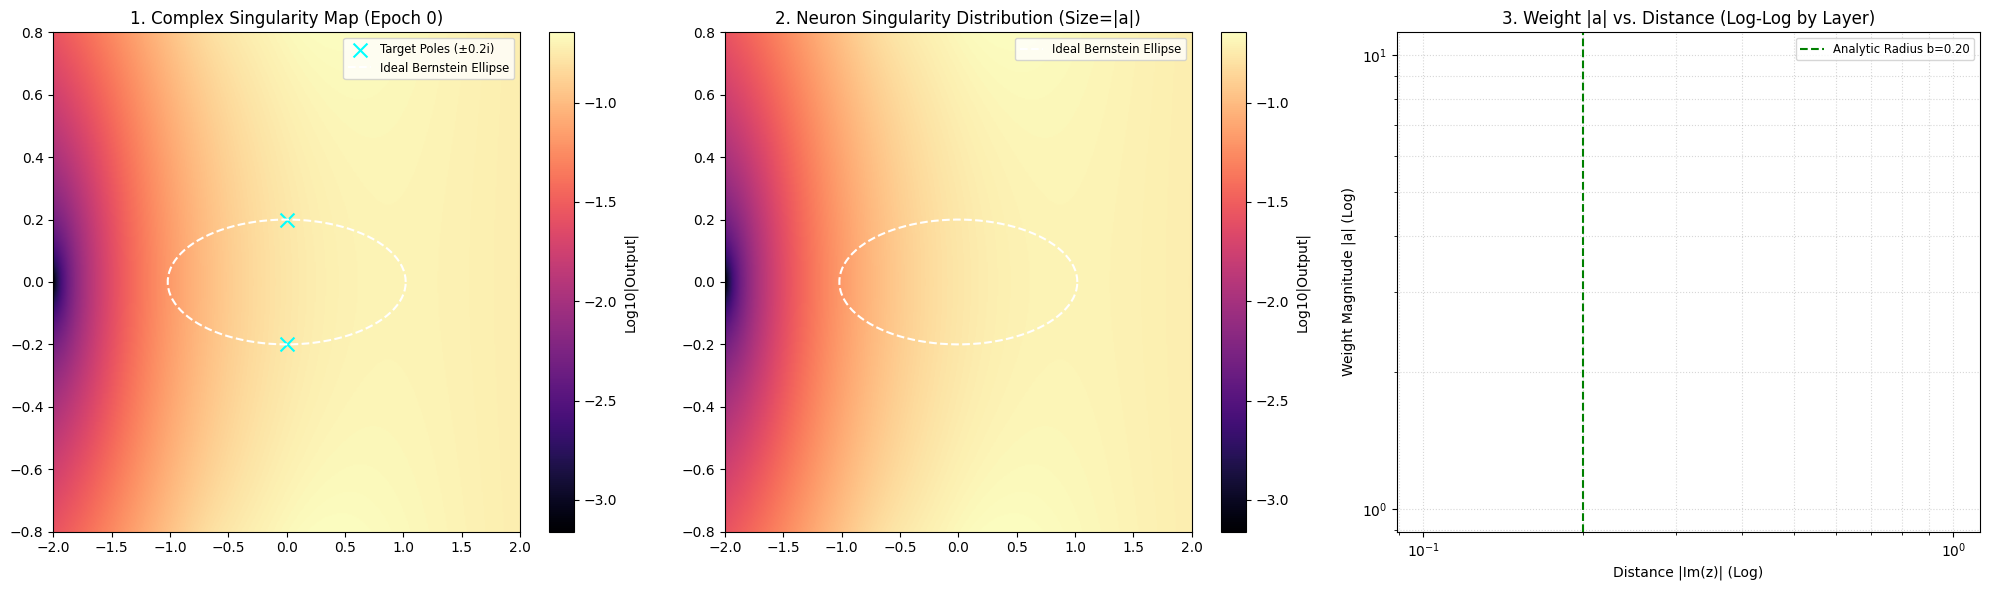

Epoch 1000, Loss: 2.57e-04


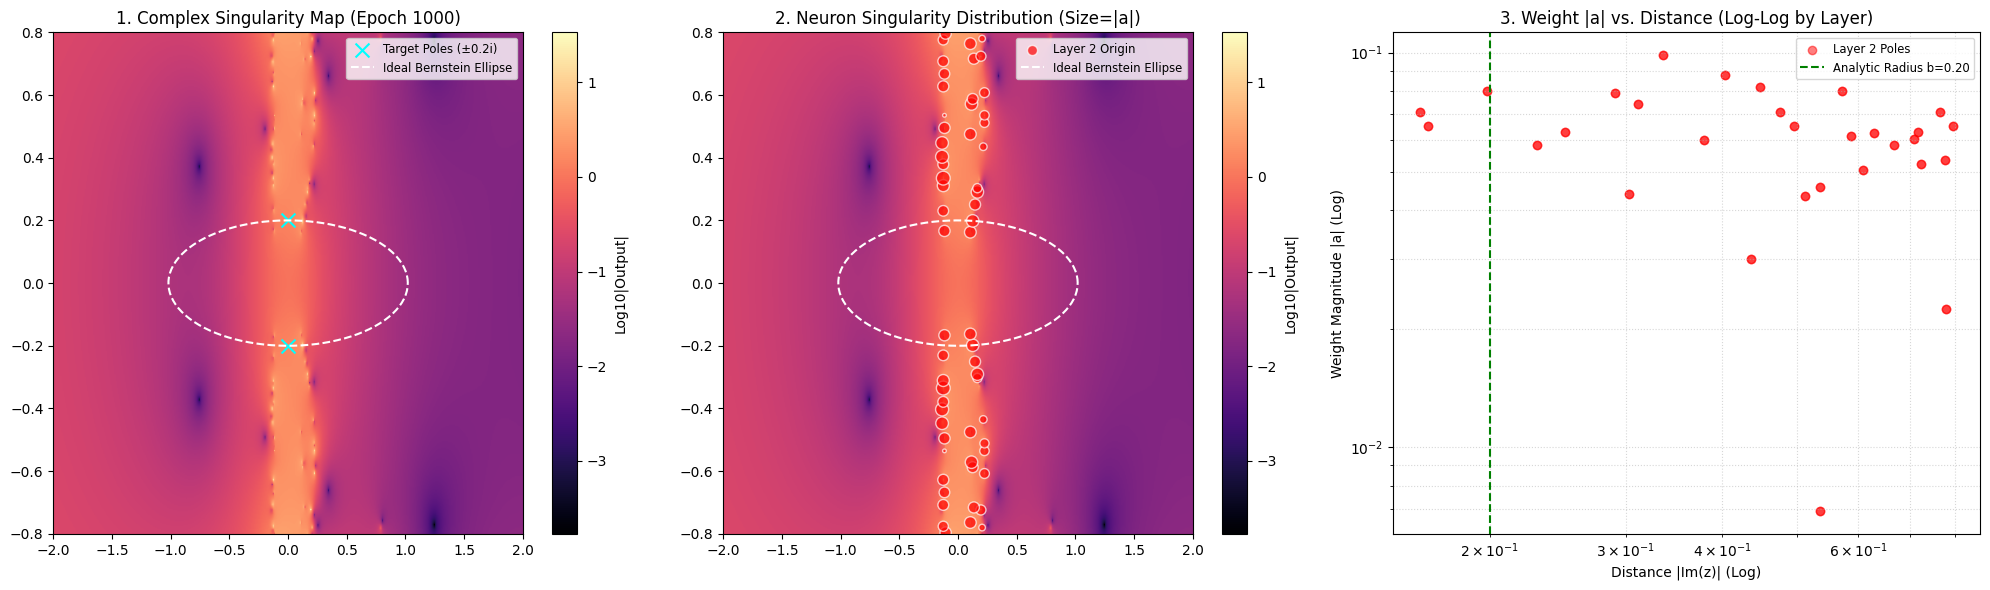

Epoch 2000, Loss: 4.34e-06


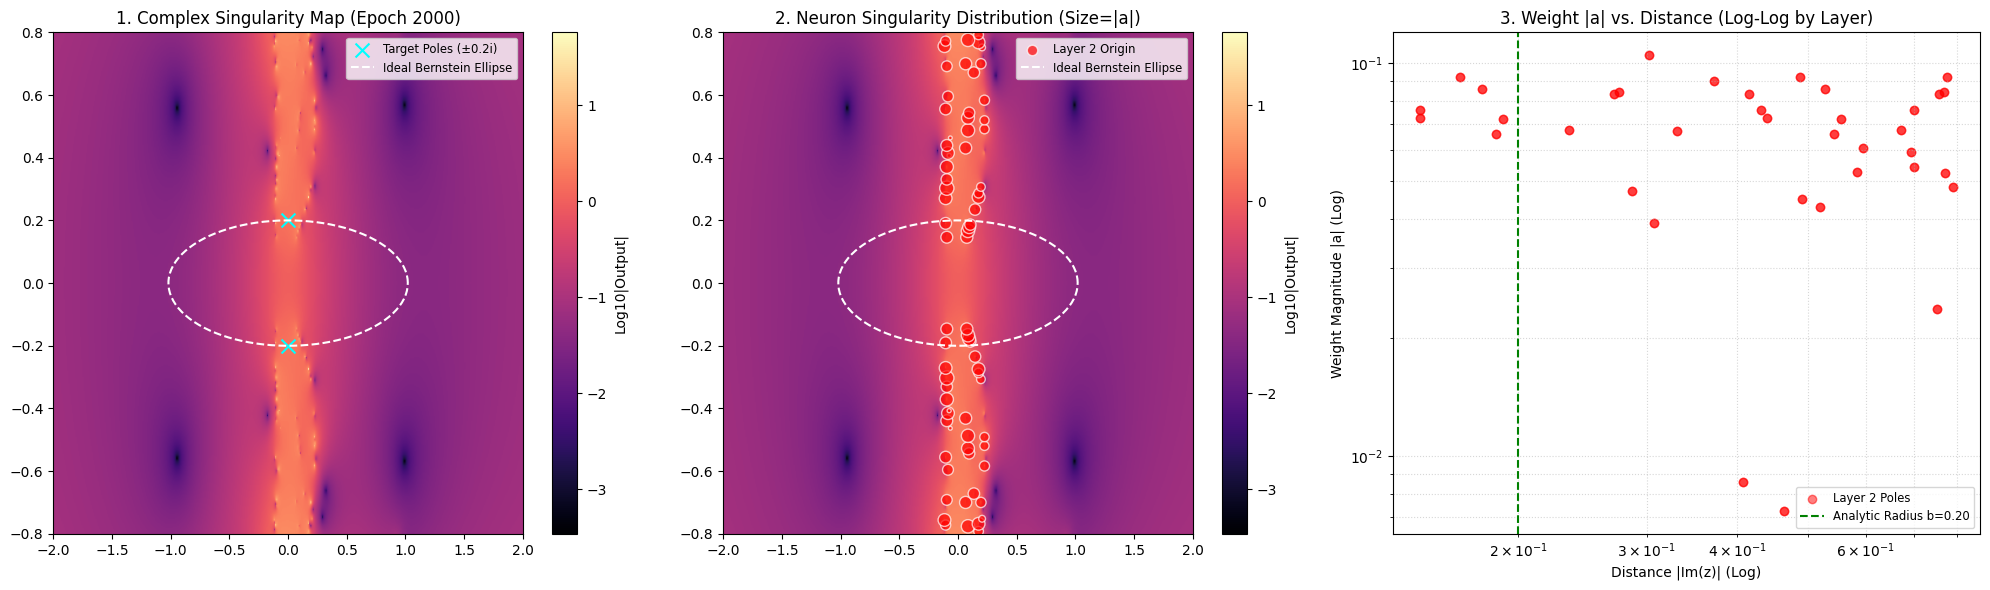

Epoch 3000, Loss: 5.96e-07


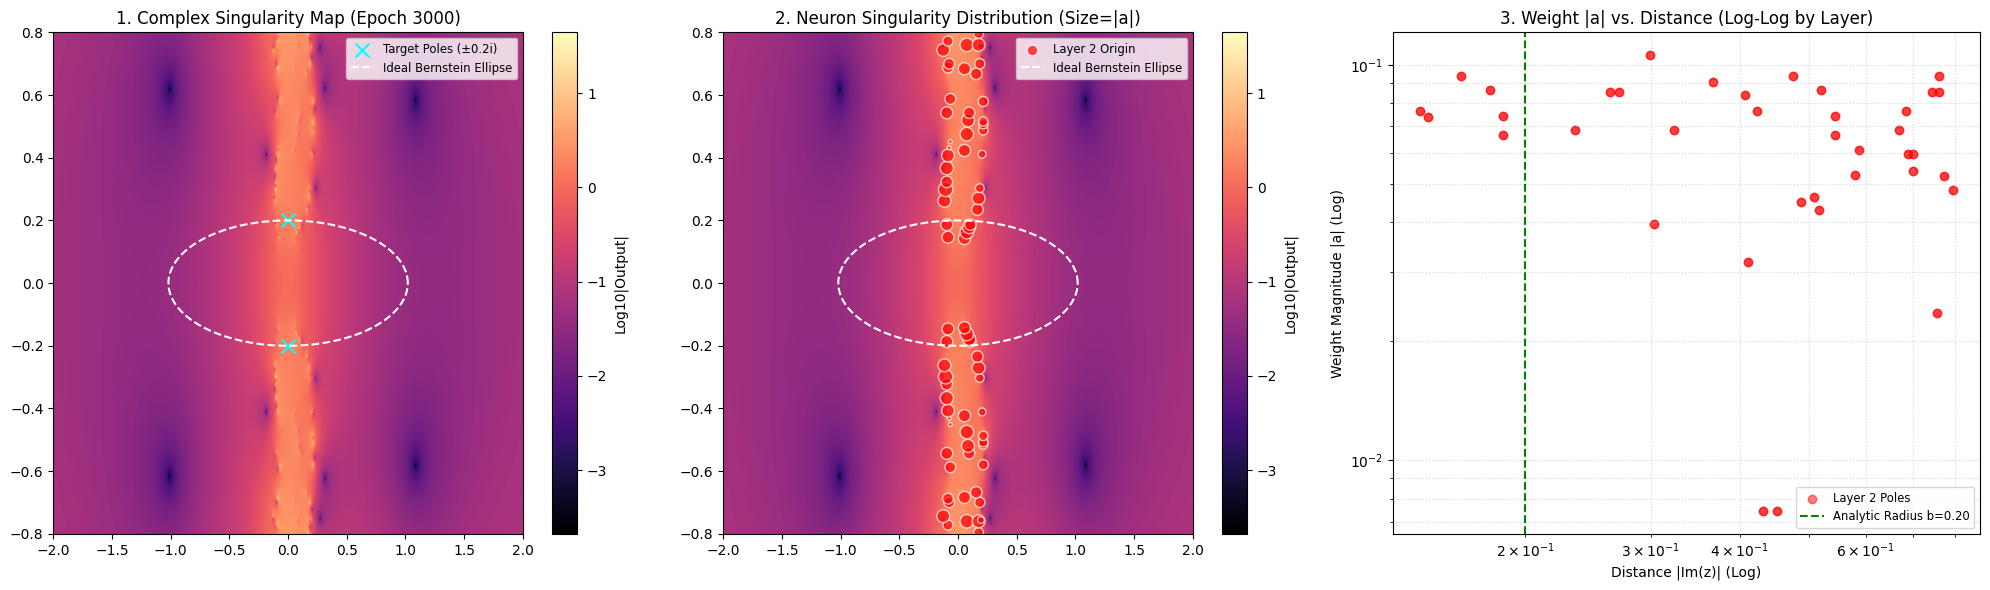

Epoch 4000, Loss: 4.46e-05


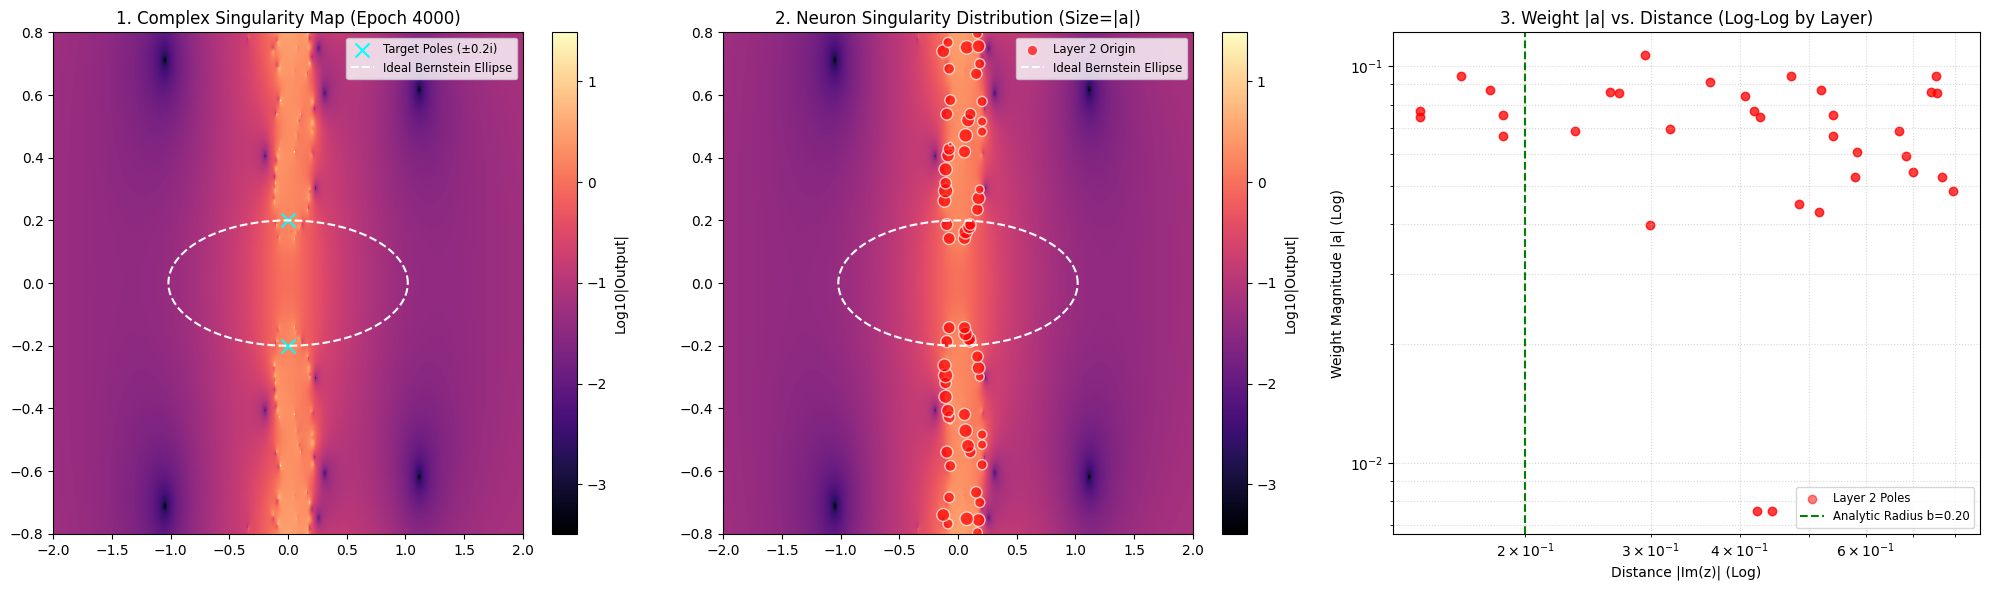

Epoch 5000, Loss: 9.87e-08


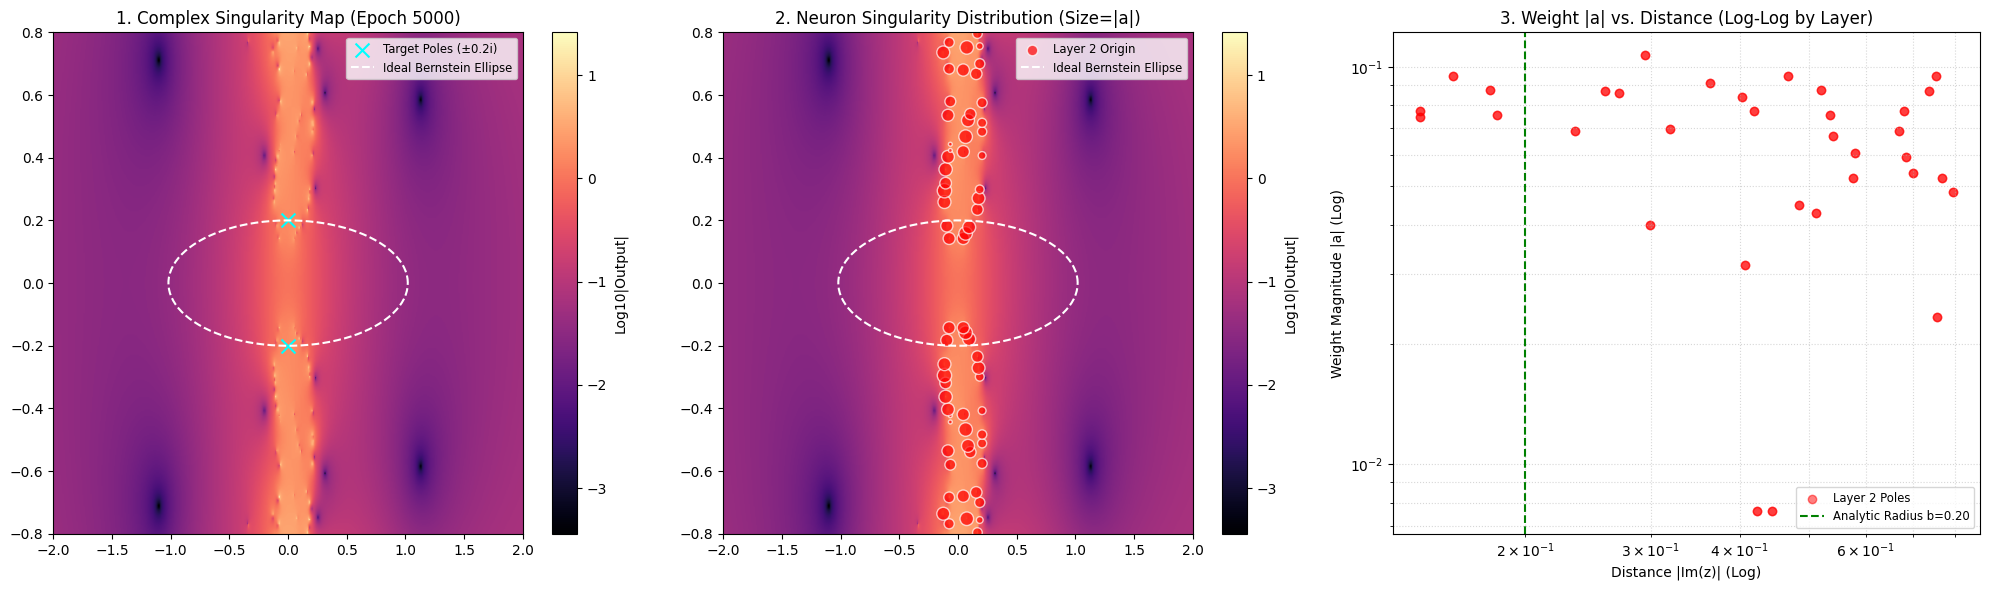

训练结束，正在生成最终 Loss 曲线...


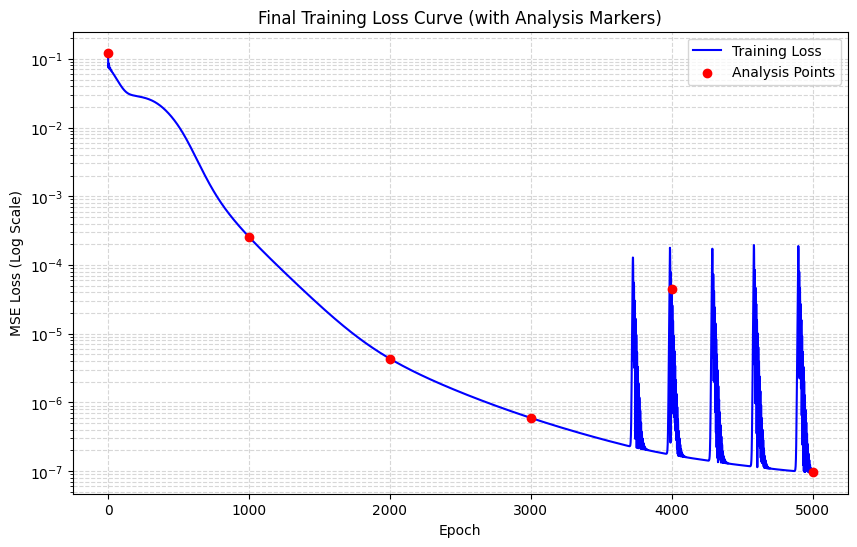

实验完成，所有图片已保存。


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 0. 挂载 Google Drive 与 路径准备
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/NN-Complex-Singularity/20260129_WeightChangeDoubleLayers/lr1e-4_epochs1000"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建文件夹: {save_dir}")
else:
    print(f"使用已有文件夹: {save_dir}")

# 1. 构建目标函数 (Runge Function)
def runge_function(x, beta=0.2):
    return 1 / (1 + (x/beta)**2)

# 2. 定义 MLP 模型 (双层隐藏层)
class DoubleLayerMLP(nn.Module):
    def __init__(self, hidden_size=64):
        super(DoubleLayerMLP, self).__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        return self.l3(x)

# 3. 解析延拓推理与归因函数
def analyze_complex_singularities(model, device, res=400):
    # 准备复平面网格
    x_range = np.linspace(-2.0, 2.0, res)
    y_range = np.linspace(-0.8, 0.8, res)
    X, Y = np.meshgrid(x_range, y_range)
    Z_grid = X + 1j * Y
    z_tensor = torch.tensor(Z_grid, dtype=torch.complex64).to(device).unsqueeze(-1)

    with torch.no_grad():
        # 第一层：h1 = tanh(w1*z + b1)
        w1, b1 = model.l1.weight.to(torch.complex64), model.l1.bias.to(torch.complex64)
        h1_pre = torch.matmul(z_tensor, w1.t()) + b1
        h1 = torch.tanh(h1_pre)

        # 第二层：h2 = tanh(w2*h1 + b2)
        w2, b2 = model.l2.weight.to(torch.complex64), model.l2.bias.to(torch.complex64)
        h2_pre = torch.matmul(h1, w2.t()) + b2
        h2 = torch.tanh(h2_pre)

        # 输出层
        w3, b3 = model.l3.weight.to(torch.complex64), model.l3.bias.to(torch.complex64)
        out = torch.matmul(h2, w3.t()) + b3
        out_abs = torch.abs(out).squeeze().cpu().numpy()

    # 奇点判断
    threshold = np.percentile(out_abs, 98)
    mask = out_abs > threshold

    found_poles = []
    found_weights = []
    found_layers = []
    activation_limit = 10.0 # 判定神经元爆炸的模值阈值

    for r in range(1, res-1):
        for c in range(1, res-1):
            if mask[r, c]:
                val = out_abs[r, c]
                # 局部极大值判断
                if val > out_abs[r-1,c] and val > out_abs[r+1,c] and val > out_abs[r,c-1] and val > out_abs[r,c+1]:
                    h1_pt = torch.abs(h1[r, c]).cpu().numpy()
                    h2_pt = torch.abs(h2[r, c]).cpu().numpy()

                    # 优先级 1：第一层权重系数查找 (归因于第1层)
                    if np.max(h1_pt) > activation_limit:
                        j1 = np.argmax(h1_pt)
                        # |a| = 对第二层连接权重的平均模值
                        eff_a = torch.mean(torch.abs(model.l2.weight[:, j1])).item()
                        found_poles.append(Z_grid[r, c])
                        found_weights.append(eff_a)
                        found_layers.append(1)
                        continue

                    # 优先级 2：第二层权重系数查找 (归因于第2层)
                    if np.max(h2_pt) > activation_limit:
                        i1 = np.argmax(h2_pt)
                        # |a| = 最后一层的权重 a_i
                        eff_a = torch.abs(model.l3.weight[0, i1]).item()
                        found_poles.append(Z_grid[r, c])
                        found_weights.append(eff_a)
                        found_layers.append(2)

    return out_abs, np.array(found_poles), np.array(found_weights), np.array(found_layers), X, Y

# 4. 训练与周期性绘图
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DoubleLayerMLP(hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

beta_val = 0.2
x_train = torch.linspace(-1, 1, 2000).view(-1, 1).to(device)
y_train = runge_function(x_train, beta=beta_val)

losses = []
plotted_epochs = [] # 用于记录绘图的轮次
total_epochs = 5001

print("开始训练并记录...")
for epoch in range(total_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # 每 1000 轮绘制并保存图像
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")
        plotted_epochs.append(epoch)

        # 分析当前状态
        out_abs, poles, weights, layers, X, Y = analyze_complex_singularities(model, device)

        plt.figure(figsize=(20, 6))

        # 图 1: 复平面推断图
        plt.subplot(1, 3, 1)
        im1 = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                        origin='lower', cmap='magma', aspect='auto')
        plt.colorbar(im1, label="Log10|Output|")
        plt.scatter([0, 0], [0.2, -0.2], color='cyan', marker='x', s=100, label="Target Poles (±0.2i)")
        # 理想伯恩斯坦椭圆
        rho = beta_val + np.sqrt(beta_val**2 + 1)
        theta = np.linspace(0, 2*np.pi, 100)
        E_z = 0.5 * (rho * np.exp(1j * theta) + 1/(rho * np.exp(1j * theta)))
        plt.plot(E_z.real, E_z.imag, 'w--', lw=1.5, label="Ideal Bernstein Ellipse")
        plt.title(f"1. Complex Singularity Map (Epoch {epoch})")
        plt.legend(loc='upper right', fontsize='small')

        # 图 2: 神经元奇点空间分布图
        plt.subplot(1, 3, 2)
        im2 = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                        origin='lower', cmap='magma', aspect='auto')
        plt.colorbar(im2, label="Log10|Output|")
        if len(poles) > 0:
            p1 = poles[layers == 1]; w1 = weights[layers == 1]
            p2 = poles[layers == 2]; w2 = weights[layers == 2]
            if len(p1) > 0:
                plt.scatter(p1.real, p1.imag, s=w1*1000, c='blue', alpha=0.7, label='Layer 1 Origin', edgecolors='white')
            if len(p2) > 0:
                plt.scatter(p2.real, p2.imag, s=w2*1000, c='red', alpha=0.7, label='Layer 2 Origin', edgecolors='white')
        plt.plot(E_z.real, E_z.imag, 'w--', lw=1.5, label="Ideal Bernstein Ellipse")
        plt.title("2. Neuron Singularity Distribution (Size=|a|)")
        plt.legend(loc='upper right', fontsize='small')

        # 图 3: 相关性趋势图
        plt.subplot(1, 3, 3)
        if len(poles) > 0:
            if len(p1) > 0: plt.scatter(np.abs(p1.imag), w1, c='blue', alpha=0.5, label='Layer 1 Poles')
            if len(p2) > 0: plt.scatter(np.abs(p2.imag), w2, c='red', alpha=0.5, label='Layer 2 Poles')
        ideal_b = 0.5 * (rho - 1/rho)
        plt.axvline(ideal_b, color='green', linestyle='--', label=f'Analytic Radius b={ideal_b:.2f}')
        plt.xscale('log'); plt.yscale('log')
        plt.title("3. Weight |a| vs. Distance (Log-Log by Layer)")
        plt.xlabel("Distance |Im(z)| (Log)"); plt.ylabel("Weight Magnitude |a| (Log)")
        plt.grid(True, which="both", ls=':', alpha=0.5); plt.legend(fontsize='small')

        plt.tight_layout()
        # 保存图片
        plt.savefig(os.path.join(save_dir, f"analysis_epoch_{epoch:05d}.png"), dpi=150)
        plt.show() # 在 Colab 中实时显示
        plt.close()

# --- 训练结束后的独立 Loss 曲线输出 ---
print("训练结束，正在生成最终 Loss 曲线...")
plt.figure(figsize=(10, 6))
plt.semilogy(losses, color='blue', label='Training Loss')

# 标记出绘图的 Epoch 点
plotted_losses = [losses[i] for i in plotted_epochs]
plt.scatter(plotted_epochs, plotted_losses, color='red', zorder=5, label='Analysis Points')

plt.title("Final Training Loss Curve (with Analysis Markers)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Log Scale)")
plt.grid(True, which="both", ls='--', alpha=0.5)
plt.legend()
plt.savefig(os.path.join(save_dir, "final_loss_curve.png"), dpi=150)
plt.show()

print("实验完成，所有图片已保存。")

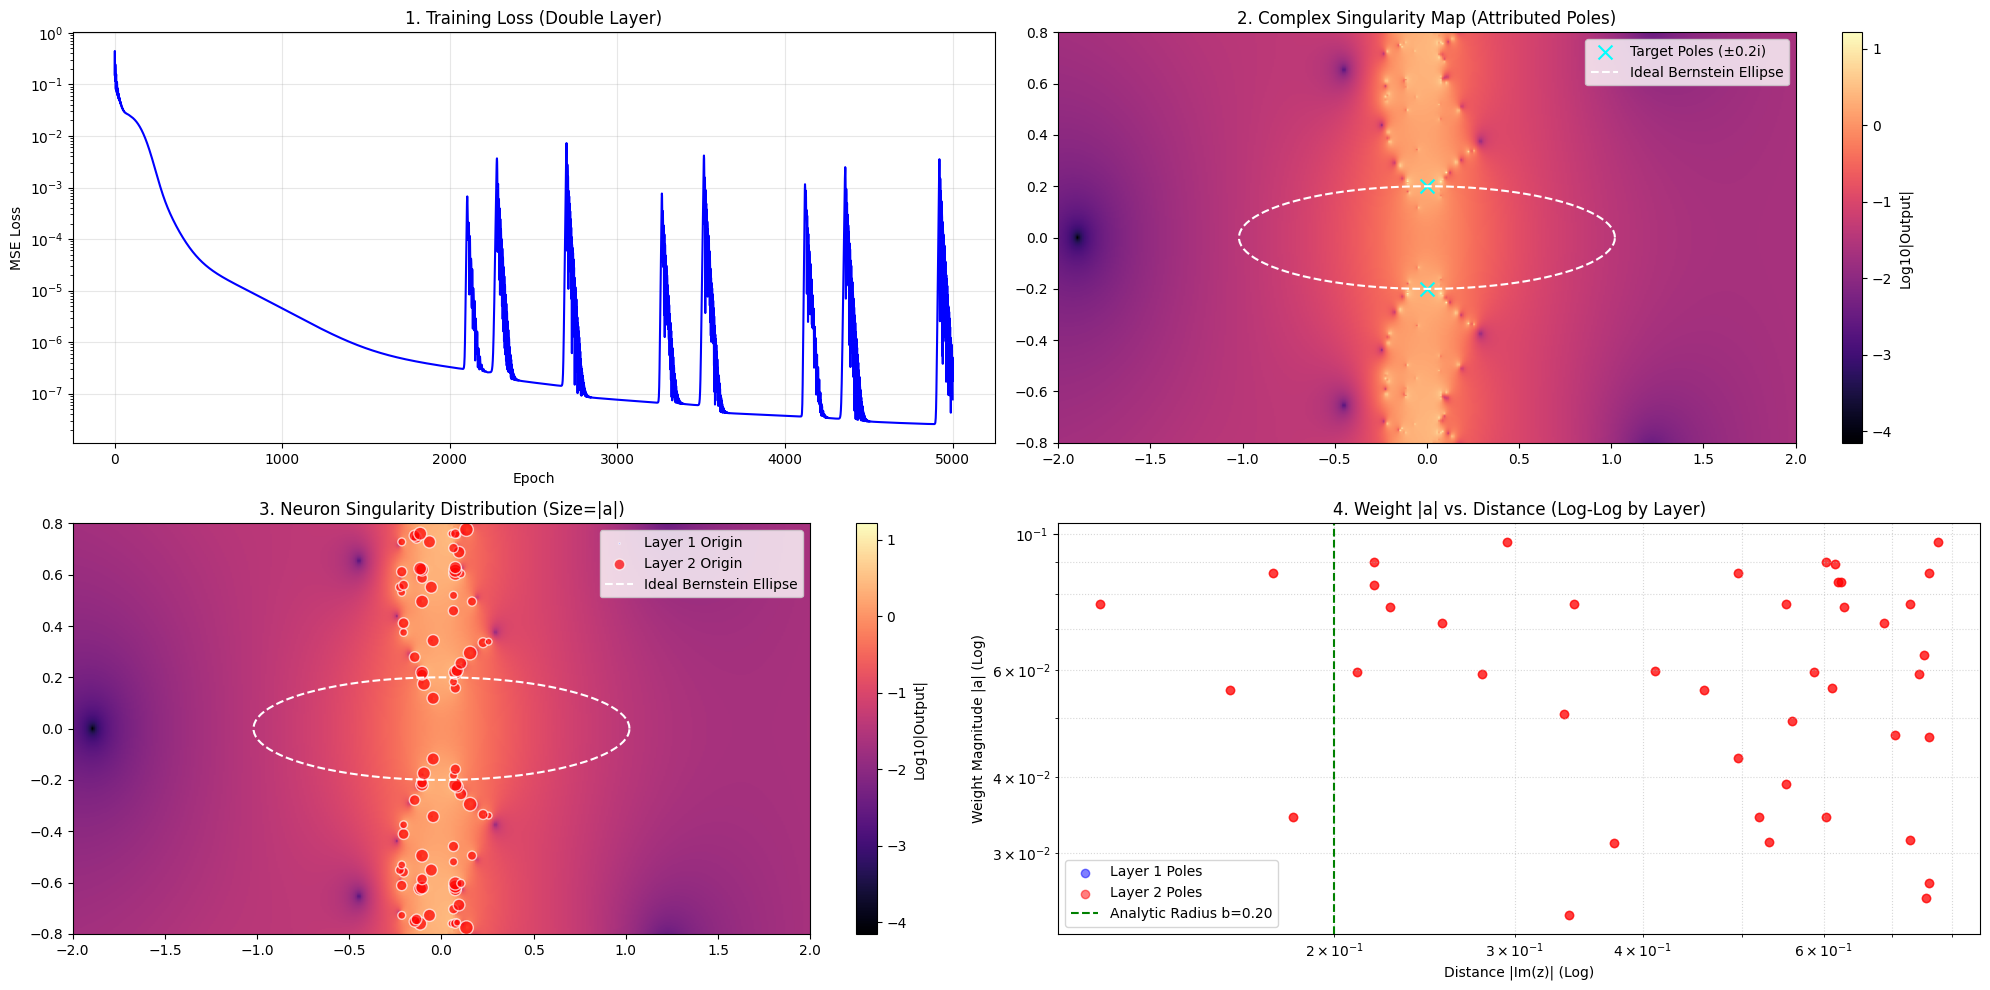

In [ ]:
plt.figure(figsize=(20, 10))

# 图 1: Loss 曲线 (保持不变)
plt.subplot(2, 2, 1)
plt.semilogy(losses, color='blue')
plt.title("1. Training Loss (Double Layer)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.grid(True, alpha=0.3)

# 图 2: 复平面推断图 (Singularity Map) - 包含层级分类
plt.subplot(2, 2, 2)
im = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                origin='lower', cmap='magma', aspect='auto')
plt.colorbar(im, label="Log10|Output|")
plt.scatter([0, 0], [0.2, -0.2], color='cyan', marker='x', s=100, label="Target Poles (±0.2i)")
# 绘制理想伯恩斯坦椭圆作为参考
rho = beta_val + np.sqrt(beta_val**2 + 1)
theta = np.linspace(0, 2*np.pi, 100)
E_z = 0.5 * (rho * np.exp(1j * theta) + 1/(rho * np.exp(1j * theta)))
plt.plot(E_z.real, E_z.imag, 'w--', lw=1.5, label="Ideal Bernstein Ellipse")
plt.title("2. Complex Singularity Map (Attributed Poles)")
plt.legend(loc='upper right')

# 图 3: 神经元奇点空间分布图 (Re-Im 分布)
plt.subplot(2, 2, 3)
im = plt.imshow(np.log10(out_abs + 1e-10), extent=[-2, 2, -0.8, 0.8],
                origin='lower', cmap='magma', aspect='auto')
plt.colorbar(im, label="Log10|Output|")

# 按层级绘制奇点：第一层(蓝色)，第二层(红色)，大小随权重变化
if len(poles) > 0:
    p1 = poles[layers == 1]; w1 = weights[layers == 1]
    p2 = poles[layers == 2]; w2 = weights[layers == 2]

    plt.scatter(p1.real, p1.imag, s=w1*1000, c='blue', alpha=0.7, label='Layer 1 Origin', edgecolors='white')
    plt.scatter(p2.real, p2.imag, s=w2*1000, c='red', alpha=0.7, label='Layer 2 Origin', edgecolors='white')

# 绘制理想伯恩斯坦椭圆作为参考
rho = beta_val + np.sqrt(beta_val**2 + 1)
theta = np.linspace(0, 2*np.pi, 100)
E_z = 0.5 * (rho * np.exp(1j * theta) + 1/(rho * np.exp(1j * theta)))
plt.plot(E_z.real, E_z.imag, 'w--', lw=1.5, label="Ideal Bernstein Ellipse")
plt.title("3. Neuron Singularity Distribution (Size=|a|)")
plt.legend(loc='upper right')

# 图 4: 相关性趋势图 (双对数坐标)
plt.subplot(2, 2, 4)
if len(poles) > 0:
    dist1 = np.abs(p1.imag); dist2 = np.abs(p2.imag)
    plt.scatter(dist1, w1, c='blue', alpha=0.5, label='Layer 1 Poles')
    plt.scatter(dist2, w2, c='red', alpha=0.5, label='Layer 2 Poles')

ideal_b = 0.5 * (rho - 1/rho)
plt.axvline(ideal_b, color='green', linestyle='--', label=f'Analytic Radius b={ideal_b:.2f}')
plt.xscale('log'); plt.yscale('log')
plt.title("4. Weight |a| vs. Distance (Log-Log by Layer)")
plt.xlabel("Distance |Im(z)| (Log)"); plt.ylabel("Weight Magnitude |a| (Log)")
plt.grid(True, which="both", ls=':', alpha=0.5); plt.legend()

plt.tight_layout()
plt.show()